In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random

#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve,auc,average_precision_score,precision_score,recall_score,f1_score
from sklearn.manifold import TSNE
from tqdm import tqdm

In [39]:
#remove randomness
def set_seed(seed):
  np.random.seed(seed)
  random.seed(seed)

Read CSV File

In [40]:
seed = 1

In [41]:
set_seed(seed)
data = pd.read_csv("E:/Research_Anomaly Detection/Taiwanese Bankruptcy Prediction (TBP)/data/TBP.csv")

X = np.array(data.drop(['Flag'], axis = 1))
y = np.array(data['Flag'].values)

#reverse
scaler = MinMaxScaler().fit(X)
X = scaler.inverse_transform(X)

#split the data to training, validation and testing data (50%,20%,30%)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,shuffle = False)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 2/7,shuffle = False)

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,shuffle = True,stratify = y)
# X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 2/7,shuffle = True,stratify = y_train)

#Minmax
scaler=MinMaxScaler().fit(X_train)

X_train=scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test=scaler.transform(X_test)

In [42]:
print(sum(y_train == 1)/len(y_train))
print(sum(y_val == 1)/len(y_val))
print(sum(y_test == 1)/len(y_test))

0.04986799647990613
0.013196480938416423
0.015640273704789834


Feature Correlation

In [43]:
corr_normal = data[data['Flag'] == 0].drop(['Flag'],axis=1).corr()
corr_anomaly = data[data['Flag'] == 1].drop(['Flag'],axis=1).corr()

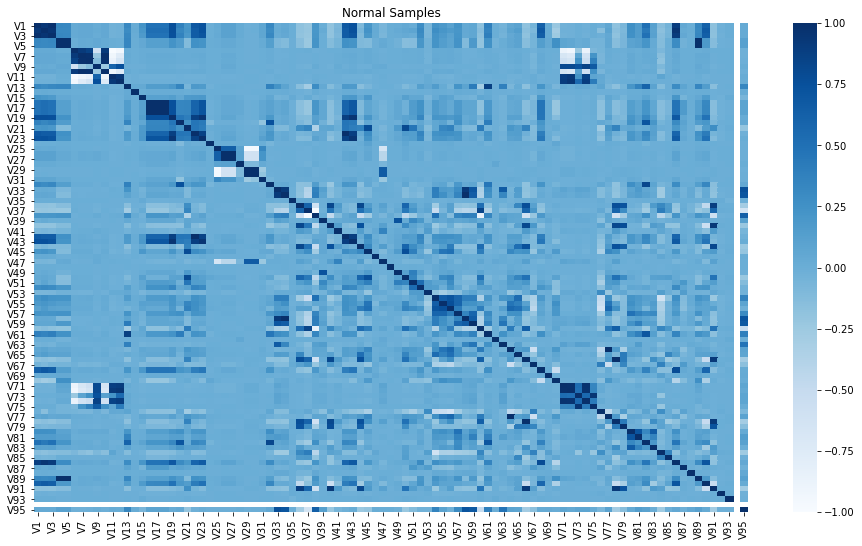

In [7]:
plt.figure(figsize=(16,9))
sns.heatmap(corr_normal,vmin=-1,vmax=1,center=0,cmap='Blues')
plt.title('Normal Samples')
plt.show()

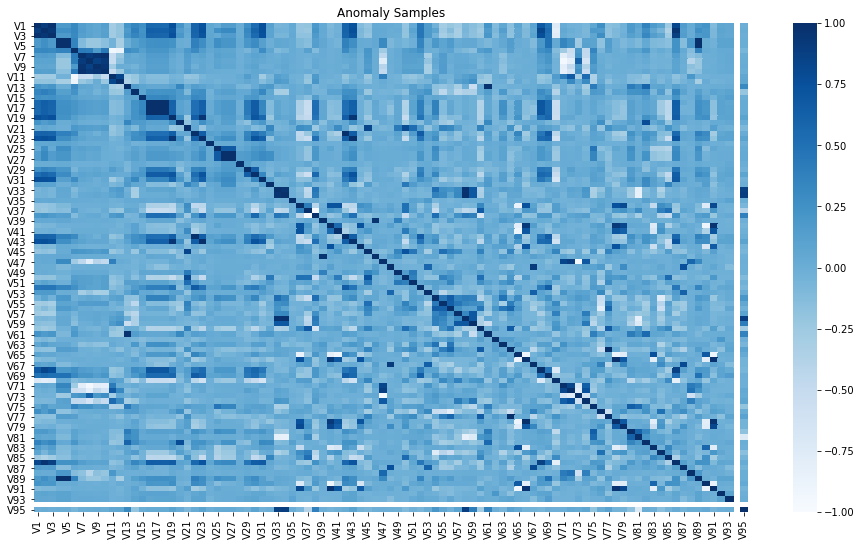

In [8]:
plt.figure(figsize=(16,9))
sns.heatmap(corr_anomaly,vmin=-1,vmax=1,center=0,cmap='Blues')
plt.title('Anomaly Samples')
plt.show()

Feature Distribution

In [9]:
def plt_dist(attribute):
  sns.distplot(data.loc[data['Flag']== 0,attribute],hist=False,rug=False,color='b',label='Normal')
  sns.distplot(data.loc[data['Flag']== 1,attribute],hist=False,rug=False,color='r',label='Anomaly')

  plt.xlabel('')
  plt.title(attribute)

F:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
F:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
F:\Anaconda\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
F:\Anaconda\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
F:\Anaconda\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


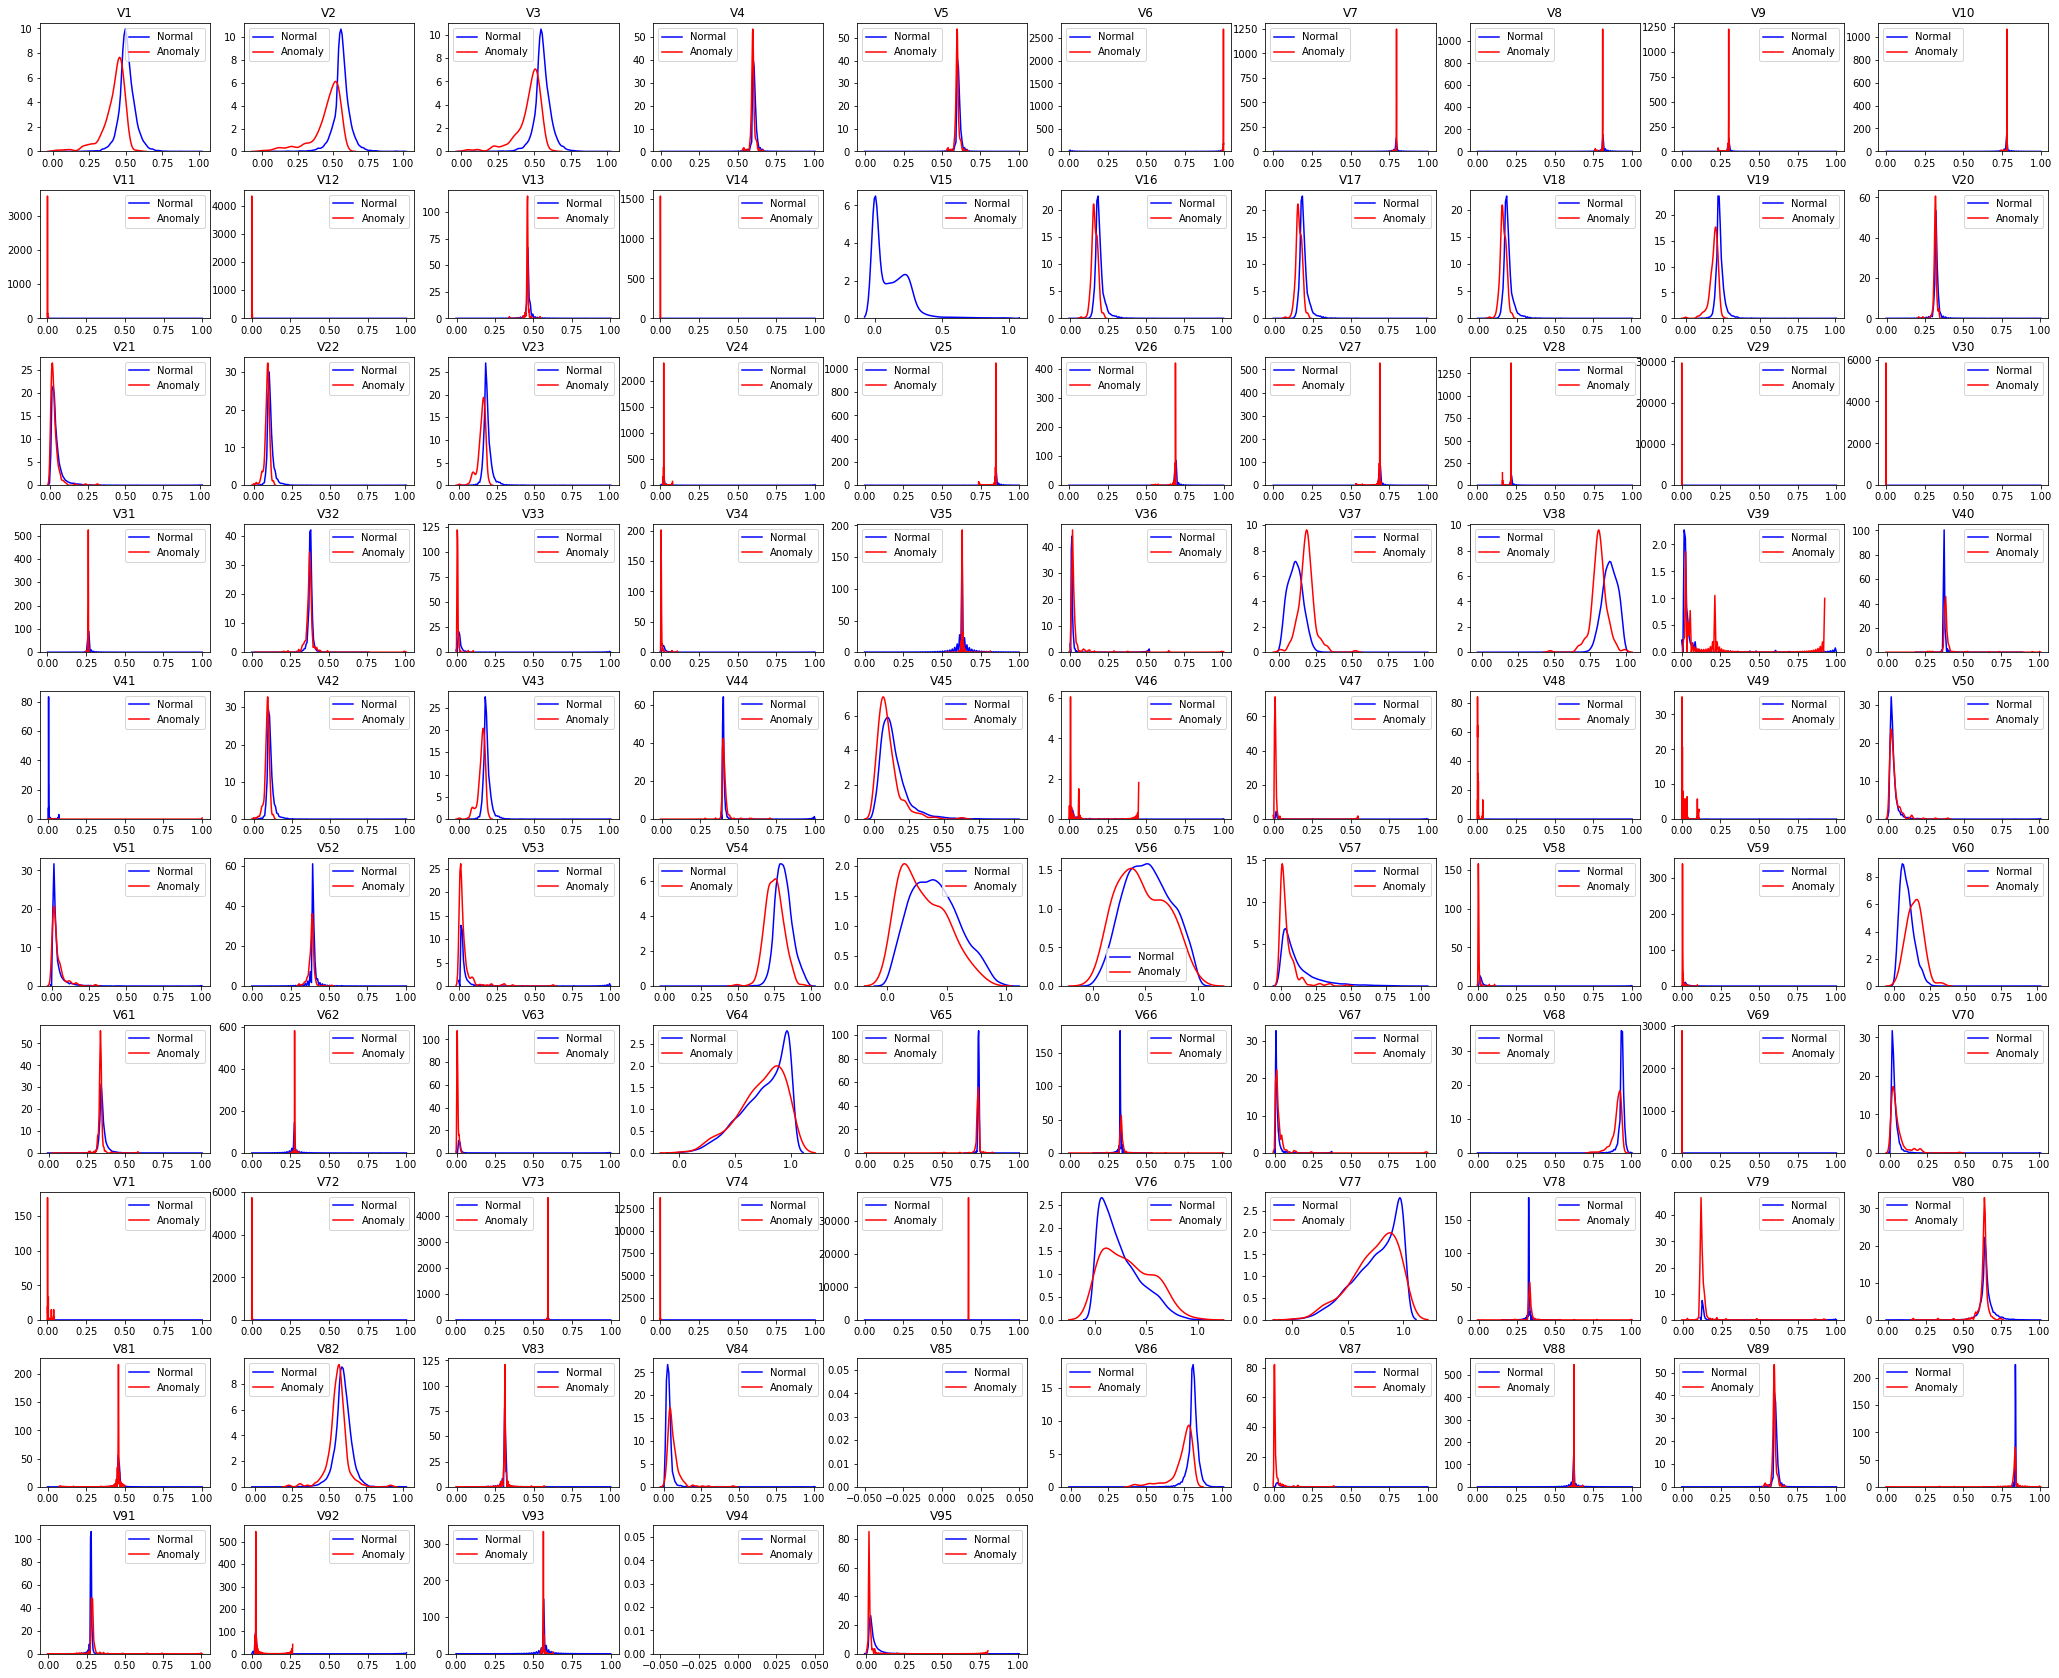

In [10]:
fig=plt.figure(figsize=(36,30))
num = np.arange(data.shape[1]-1)+1
for i in range(len(num)):
  fig.add_subplot(10,10,i+1)
  plt_dist(attribute='V'+str(num[i]))

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

Feature Selection by LGB

In [11]:
#feature selection using LGB
import lightgbm as lgb 
from sklearn.metrics import classification_report
from itertools import product

hyper_colsample_bytree = [0.6,0.8,1]
hyper_learning_rate = [0.05,0.1,0.15]
hyper_n_estimators = [50,100,150]
hyper_reg_alpha = [0.01,0.1,1]
hyper_reg_lambda = [0.01,0.1,1]
hyper_list_entire = list(product(hyper_colsample_bytree,hyper_learning_rate,hyper_n_estimators,hyper_reg_alpha,hyper_reg_lambda))

search_size = 10

In [12]:
def random_search(hyper_list_entire,search_size,seed):
  if search_size < len(hyper_list_entire):
    set_seed(seed)
    index = np.random.choice(np.arange(len(hyper_list_entire)),search_size,replace = False)

    hyper_list = []
    for i in index:
      hyper_list.append(hyper_list_entire[i])
  else:
    hyper_list = hyper_list_entire

  return hyper_list

In [13]:
#finding the best hyperparameter
metric_value_list=list()
hyper_list = random_search(hyper_list_entire,search_size,seed)


for i in tqdm(range(len(hyper_list))):
    try:
      print(f'Finding Optimal Hyper-parameters......Current Candidates: {hyper_list[i]}')

      colsample_bytree,learning_rate,n_estimators,reg_alpha,reg_lambda = hyper_list[i]
      model = lgb.LGBMClassifier(colsample_bytree = colsample_bytree,learning_rate = learning_rate, n_estimators = n_estimators,
                                 reg_alpha = reg_alpha, reg_lambda = reg_lambda, random_state = seed)

      model.fit(X_train,y_train)

      #evaluation
      score = model.predict_proba(X_val)[:,1]
      metric_value = average_precision_score(y_true = y_val,y_score = score,pos_label = 1)
      metric_value_list.append(metric_value)

      print(f'The metric value corresponded to the hyper-parameters is :{metric_value:{.4}}')
      print('******************************')
      print('\n')
    except:
      pass
    continue

best_hyper_params = hyper_list[metric_value_list.index(max(metric_value_list))]

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Finding Optimal Hyper-parameters......Current Candidates: (0.6, 0.15, 100, 0.1, 0.1)


 10%|████████▎                                                                          | 1/10 [00:01<00:11,  1.28s/it]

The metric value corresponded to the hyper-parameters is :0.2411
******************************


Finding Optimal Hyper-parameters......Current Candidates: (1, 0.15, 150, 1, 1)


 20%|████████████████▌                                                                  | 2/10 [00:02<00:10,  1.28s/it]

The metric value corresponded to the hyper-parameters is :0.2856
******************************


Finding Optimal Hyper-parameters......Current Candidates: (1, 0.1, 100, 1, 0.1)


 30%|████████████████████████▉                                                          | 3/10 [00:04<00:10,  1.55s/it]

The metric value corresponded to the hyper-parameters is :0.2893
******************************


Finding Optimal Hyper-parameters......Current Candidates: (0.8, 0.1, 100, 0.1, 1)


 40%|█████████████████████████████████▏                                                 | 4/10 [00:06<00:09,  1.56s/it]

The metric value corresponded to the hyper-parameters is :0.2675
******************************


Finding Optimal Hyper-parameters......Current Candidates: (0.8, 0.05, 50, 1, 1)


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:07<00:06,  1.34s/it]

The metric value corresponded to the hyper-parameters is :0.2894
******************************


Finding Optimal Hyper-parameters......Current Candidates: (1, 0.15, 50, 0.01, 0.1)


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:08<00:05,  1.29s/it]

The metric value corresponded to the hyper-parameters is :0.2254
******************************


Finding Optimal Hyper-parameters......Current Candidates: (0.6, 0.15, 50, 0.1, 0.1)


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:09<00:03,  1.14s/it]

The metric value corresponded to the hyper-parameters is :0.2433
******************************


Finding Optimal Hyper-parameters......Current Candidates: (1, 0.05, 150, 0.1, 1)


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:12<00:03,  1.80s/it]

The metric value corresponded to the hyper-parameters is :0.3103
******************************


Finding Optimal Hyper-parameters......Current Candidates: (1, 0.05, 100, 0.1, 1)


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:14<00:01,  1.79s/it]

The metric value corresponded to the hyper-parameters is :0.2976
******************************


Finding Optimal Hyper-parameters......Current Candidates: (0.6, 0.05, 50, 0.1, 0.1)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.50s/it]

The metric value corresponded to the hyper-parameters is :0.3109
******************************




In [14]:
#retrain based on the best-hyperparameter
colsample_bytree,learning_rate,n_estimators,reg_alpha,reg_lambda = best_hyper_params
model = lgb.LGBMClassifier(colsample_bytree = colsample_bytree,learning_rate = learning_rate, n_estimators = n_estimators,
            reg_alpha = reg_alpha, reg_lambda = reg_lambda, random_state = seed)
model.fit(X_train,y_train)

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.05, n_estimators=50,
               random_state=1, reg_alpha=0.1, reg_lambda=0.1)

In [15]:
print(classification_report(y_pred = model.predict(X_test),y_true = y_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2014
           1       0.58      0.34      0.43        32

    accuracy                           0.99      2046
   macro avg       0.78      0.67      0.71      2046
weighted avg       0.98      0.99      0.98      2046



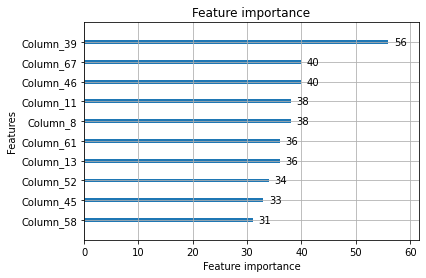

In [16]:
lgb.plot_importance(model,max_num_features=10)

In [17]:
data_select = data.iloc[:,np.append(0,np.argsort(-model.feature_importances_)[:20]+1)]

In [18]:
data_select.to_csv('E:/Research_Anomaly Detection/Taiwanese Bankruptcy Prediction (TBP)/data/TBP_LGB.csv',index = False)

Feature Selection by PCA

In [44]:
from sklearn.decomposition import PCA

In [45]:
pca = PCA(n_components = 20,random_state = seed).fit(X_train)

In [ ]:
data.to_csv('E:/Research_Anomaly Detection/Taiwanese Bankruptcy Prediction (TBP)/data/TBP_PCA.csv',index = False)

In [37]:
pca.transform(data.iloc[:,1:])

array([[ 4.63883510e-01, -2.64348487e-01, -1.63270713e-01, ...,
        -3.86254653e-02, -2.31822767e-02,  2.07286186e-02],
       [ 8.07949694e-01,  1.59411400e-01, -1.03158611e-01, ...,
         5.69500136e-03, -7.59634761e-03,  4.46742757e-03],
       [ 3.33321639e-01,  2.38501190e-01, -2.80640473e-01, ...,
        -2.30433088e-02, -1.18590724e-02,  7.20659254e-05],
       ...,
       [ 2.76076748e-02,  4.07046583e-01,  7.90179071e-02, ...,
         4.66920566e-02,  4.13257670e-03, -1.88070961e-02],
       [-1.17704589e-01, -1.33386718e-01,  7.13114744e-02, ...,
         1.87012389e-02,  3.64521496e-03, -1.39082285e-02],
       [-3.44887748e-01, -1.14513583e-01,  6.90329309e-02, ...,
         1.29500701e-02,  2.21859533e-02, -3.19167387e-02]])